In [58]:
#https://medium.com/@curiousily/making-a-predictive-keyboard-using-recurrent-neural-networks-tensorflow-for-hackers-part-v-3f238d824218
# note: I trained on alice in wonderland, about 1/4 the length of his Nietzsche data set.
# I also tested with "seeds" that come from his Nietzsche examples!
# TODO - why does validation not go down?   
#    - what happens if you let it run further by itself? 
#   - Use  GRU instead of LSTM

import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, GRU, Dropout,BatchNormalization
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
from keras import regularizers
import matplotlib.pyplot as plt
import pickle
import sys
import os

from keras.callbacks import ModelCheckpoint

import heapq
import seaborn as sns
from pylab import rcParams


%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 12, 5

In [59]:
#trainP=True
useNietzsche=False
useCarroll=True
useShakespeare=False

LOGDIR="FTP"
RUNNAME = "nietStep3Seq60bn"
FILENAME=LOGDIR + "/" + RUNNAME

#get parameters from training param file
with open(FILENAME + '.params.pkl', 'rb') as f:  
    param = pickle.load(f)
for key, value in param.items():
    print(key,  " : ", value)

#assign the ones we need for analysis & visualization
SEQUENCE_LENGTH = param['SEQUENCE_LENGTH']
EPOCHS = param['EPOCHS']
step = param['step']
layer1size = param['layer1size']
lenAugmentedInput = param['lenAugmentedInput']

# paramaeters for reconstructions
topN=1
topNStartWord=3
k_phraseLength=100

k_condNietzsche=[1,0,0]
k_condCarroll=[0,1,0]
k_condShakespeare=[0,0,1]
lenconditional=len(k_condNietzsche)


SEQUENCE_LENGTH  :  60
step  :  3
layer1size  :  128
FILENAME  :  LOG/nietStep3Seq60bn
k_validationSplit  :  0.09917355371900827
RUNNAME  :  nietStep3Seq60bn
k_batchsize  :  128
k_shuffle  :  True
EPOCHS  :  20
k_stateful  :  False
k_bn  :  True
k_layers  :  1


In [60]:
#This cell exists ONLY to get lenAugmentedInput.
# Ideally we could read these parameters from a file created by CharTrainier so we wouldn't have to read in, clean, and process all the text again.

import re as re
def cleanText(text) :
    # replace all numbers followed by an optional letter and then a dot (eg numbered paragraphs)                                    
    text = re.sub("(^|\W)\d+[a-zA-Z]*($|\W|\.)", "", text)
    #escaped apotrophes                                                                                                             
    #text = text.replace('\n', ' ').replace("\'", "'").replace("\"","").replace('[Illustration]',"").replace('*',"")
    text = text.replace("\'", "'").replace("\"","").replace('[Illustration]',"").replace('*',"")
    #repeated white space
    text=re.sub('â', 'a', text)
    text=re.sub('æ', 'a', text)
    text=re.sub('è', 'e', text)
    text=re.sub('ï', 'i', text)
    text=re.sub('ù', 'u', text)
    text=re.sub('&c', 'etc', text)
    text=re.sub('\ufeff', '', text)
    text=re.sub('‘', "'", text)
    text=re.sub('’', "'", text)
    text=re.sub('“', "'", text)
    text=re.sub('”', "'", text)

    # try to normalize Carroll text a bit more, although there are still way more contractions in carrll than nietzsche             
    text=re.sub('!', " ", text)
    text=re.sub('\?', " ", text)
#                                                                                                                                   
    text=re.sub('--', " ", text)
    text=re.sub('_', " ", text)

    #repeated white space                                                                                                           
    text=re.sub('\s{2,}',' ', text)

    return text

text1=""
text2=""
text3=""

if useNietzsche :
    path = 'nietzsche.txt'
    text1 = cleanText(open(path, 'r', encoding='utf-8').read().lower())
    print('corpus 1 length:', len(text1))
    print("NIETZSCHE CHARS: ", sorted(list(set(text1))))
    
if useCarroll :
    path = 'carroll.txt'
    text2 = cleanText(open(path, 'r', encoding='utf-8').read().lower())
    print('corpus 2 length:', len(text2))
    print("CARROLL CHARS: ", sorted(list(set(text2))))

if useShakespeare :
    path = 'shakespeare.txt'
    text3 = cleanText(open(path, 'r', encoding='utf-8').read().lower())
    print('corpus 3 length:', len(text3))
    print("SHAKESPEARE CHARS: ", sorted(list(set(text3))))
    
text=text1+text2+text3
print('total cleaned corpus length is ', len(text))

chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

lenchars=len(chars)
lenAugmentedInput=lenchars+lenconditional

print(f'unique chars: {len(chars)}')


corpus 2 length: 331969
CARROLL CHARS:  [' ', "'", '(', ')', ',', '-', '.', '0', '1', '3', ':', ';', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
total cleaned corpus length is  331969
unique chars: 38


In [61]:
text1

''

In [62]:
text2

"alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, and where is the use of a book, thought alice, without pictures or conversations so she was considering in her own mind, (as well as she could, for the hot day made her feel very sleepy and stupid,) whether the pleasure of making a daisy-chain was worth the trouble of getting up and picking the daisies, when a white rabbit with pink eyes ran close by her. there was nothing very remarkable in that, nor did alice think it so very much out of the way to hear the rabbit say to itself dear, dear i shall be too late (when she thought it over afterwards, it occurred to her that she ought to have wondered at this, but at the time it all quite natural); but when the rabbit actually took a watch out of its waistcoat-pocket, looked at it, and then hurried on, alice started to her 

In [63]:

# check to make sure the save worked
modelOrig = load_model(FILENAME + '.keras_model.h5')
history = pickle.load(open(FILENAME + '.history.p', "rb"))




In [64]:
#for making predictions, we need a model that can take in a batch size of 1
# construct a new model and copy weights.

k_layers = param['k_layers']
layer1size = param['layer1size']
k_stateful = param['k_stateful']
SEQUENCE_LENGTH = param['SEQUENCE_LENGTH']
k_bn = param['k_bn']


model = Sequential()

if (k_layers==1) :
    model.add(LSTM(layer1size,  batch_size=1, stateful=k_stateful, input_shape=(SEQUENCE_LENGTH, lenAugmentedInput)))
else :
    model.add(LSTM(layer1size,   batch_size=1, stateful=k_stateful, return_sequences=True, input_shape=(SEQUENCE_LENGTH, lenAugmentedInput)))

if (k_bn) : 
    model.add(BatchNormalization())

if (k_layers==2) :
    model.add(LSTM(layer1size))
    
model.add(Dense(lenchars))
model.add(Activation('softmax'))

model.set_weights(modelOrig.get_weights())

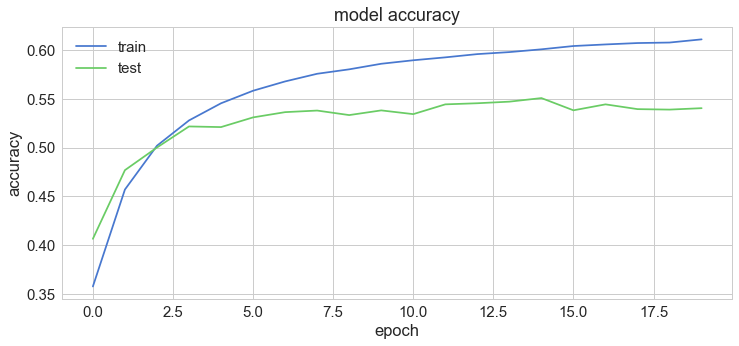

In [65]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

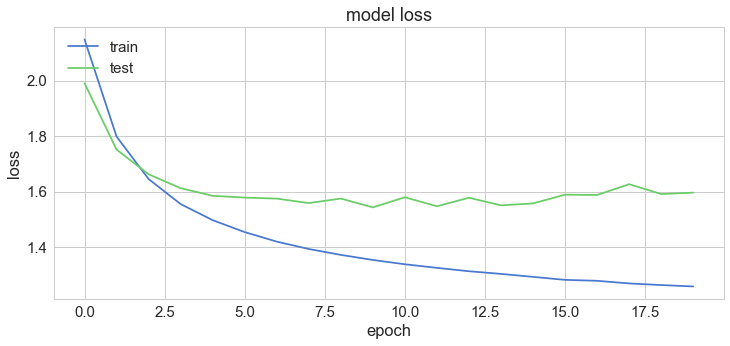

In [66]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [67]:
# create one-hot represetntation of input (will be padded with 0 vectors if text < SEQUENCE_LENGTH chars)
def prepare_input_old(text):
    print("will prepare: ", text)
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))  

    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [68]:
# changes "oldest" element in buffer to new element, then rolls the circular buffer 
def shift(c,condval,buf) :
    buf[0,0].fill(0)
    buf[0,0,char_indices[c]]=1
    buf[0,0,-lenconditional:]=condval
    buf[0]=np.roll(buf[0],-1, 0)
    return buf
    
# create one-hot represetntation of input (will be padded with 0 vectors if text < SEQUENCE_LENGTH chars)
def prepare_input(text,condval):
    print("will prepare: ", text)
    x = np.zeros((1, SEQUENCE_LENGTH, lenAugmentedInput))  
    for t, char in enumerate(text):
        shift(char, condval, x)      
    return x

In [69]:
# preds is an array of scores greater than 0 for each letter
# sample(preds) return the indexes of the n highest
#
# NOTE: If you aren't going to throw the dice, why not just take the 3 largest in the preds array directly?
#
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    #print('preds are ', preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take) # 3rd arg is a 1-arg function used as key for sorting

In [70]:
# preds is an array of scores unnormalized scores (logits)
# rsample(preds) Selects top_n, then throws dice to choose them in a randomized order based on their relative prob.

def rsample(preds, top_n=3, verbose=0):
    preds = np.asarray(preds).astype('float64')
    
    exp_preds = np.exp(preds)
    #sm=np.sum(exp_preds)
    preds = exp_preds / exp_preds.sum(0)
    
    # indexes of largest vals in preds, orders large to small
    idx = heapq.nlargest(top_n, range(len(preds)), preds.take)
    # and their values
    vals = np.take(preds, idx )
    #normalized (for np.random.choice)
    vals=vals/vals.sum(0)
    
    if (verbose == 1) :
        print("probability vals are ", vals)
    your_samples = np.random.choice(idx, size=top_n, replace=False,p=vals)
    return your_samples


In [71]:
# test sampling the probablity distribution
bar=[2,2,3,4,5,6]
rs = rsample(bar, top_n=3, verbose=1)
print("rsample: ", rs)
print("sample: ", sample(bar))
count=np.zeros(len(bar))
for i in range(10000) :
    foo=rsample(bar, top_n=topN)
    #foo=sample(bar, top_n=topN)
    #print("foo = ", foo)
    for j in range(len(bar)) :
        if j == foo[0] :
            count[j]=count[j]+1

for j in range(len(bar)) :
    print(" count ", str(j), " = ", str(count[j]))
    

probability vals are  [ 0.66524096  0.24472847  0.09003057]
rsample:  [5 4 3]
sample:  [5, 4, 3]
 count  0  =  0.0
 count  1  =  0.0
 count  2  =  0.0
 count  3  =  0.0
 count  4  =  0.0
 count  5  =  10000.0


In [72]:
def predict_completion_old(text):
    print("predict_completion for: ", text)
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = rsample(preds, top_n=topN)[0] # SAMPLE
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        print("len is ", len(original_text + completion))
        if (len(original_text + completion) + 2 > len(original_text) and next_char == ' ') or (len(original_text + completion) > 100) : 
            return completion

In [73]:
def wordEnd(c) :
    if c in [' ', ';', '.', '!', ',', '?'] : 
        return True
    else :
        return False

def predict_completion(text, condval):
    print("predict_completion for: ", text)
    original_text = text
    generated = text
    completion = ''

    next_char=text[-1]
    
    x = prepare_input(text, condval)
    while True:
        
        preds = model.predict(x, verbose=0)[0]
        
        if (wordEnd(next_char)) : #if we are about to start a new word
            next_index = rsample(preds, top_n=topNStartWord)[0] # SAMPLE
        else :
            #can add a little more randomness so we don't get stuck in repetitions at the word level
            next_index = rsample(preds, top_n=topN)[0] # SAMPLE
                
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        

        if len(original_text + completion) > k_phraseLength : 
            print("Extended text is : ", original_text + completion)
            return completion
        
        #if (len(original_text + completion) + 2 > len(original_text) and next_char == ' ') or (len(original_text + completion) > k_phraseLength100) :
        #    return completion
        
        x=shift(next_char, condval, x)
        

In [74]:
# predict n different completions for the first 40 characters of text.
def predict_completions(text, condval, n=3 ):
    x = prepare_input(text, condval)
    preds = model.predict(x, verbose=0)[0]
    next_indices = rsample(preds, n)  # SAMPLE (for the character folloiwng the input)
    print("Will predict completions for the indices : ", [indices_char[idx] for idx in next_indices])
    return [indices_char[idx] + predict_completion(text[0:] + indices_char[idx], condval) for idx in next_indices]


In [75]:
#quotes = [
#    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
#    "That which does not kill us makes us stronger.",
#    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
#    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
#    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
#]
#

#quotes = [
#    "It is not a lack of love, but a lack of friendship that makes unhappy marriages"
#    #"It is not a lack of love, but a lack of friendship that makes un"
#]

quotes = [
    "after you hear the word eleph",
    "friendship that makes unhappy ",
    "That which does not kill us makes us "
]

for q in quotes:
    seq = q[-SEQUENCE_LENGTH:].lower()
    print(seq)
    print("... and the completions are : " , predict_completions(seq, k_condCarroll, 5 ))
    print()

after you hear the word eleph
will prepare:  after you hear the word eleph
Will predict completions for the indices :  ['0', ';', ' ', 'i', ':']
predict_completion for:  after you hear the word eleph0
will prepare:  after you hear the word eleph0
Extended text is :  after you hear the word eleph0h e lit est:eo v e ce athee0inelert s utinalan(tonce0t romah looeshrnid
predict_completion for:  after you hear the word eleph;
will prepare:  after you hear the word eleph;
Extended text is :  after you hear the word eleph;e n h;hshl; o 0ash;raztr azh t;o it:hich;;, thac;s e there sitil:eu; eo
predict_completion for:  after you hear the word eleph 
will prepare:  after you hear the word eleph 
Extended text is :  after you hear the word eleph ;du;eit0cyive,  ooro (bomehthatine h:at it; gat ;ri t: oateet; is es;an
predict_completion for:  after you hear the word elephi
will prepare:  after you hear the word elephi
Extended text is :  after you hear the word elephih  p;utt rulle na: ouit lroh;1y

In [76]:
#quotes = [
#    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
#    "That which does not kill us makes us stronger.",
#    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
#    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
#    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
#]
#

#quotes = [
#    "It is not a lack of love, but a lack of friendship that makes unhappy marriages"
#    #"It is not a lack of love, but a lack of friendship that makes un"
#]

quotes = [
    "after you hear the word eleph",
    "friendship that makes unhappy ",
    "That which does not kill us makes us "
]

for q in quotes:
    seq = q[-SEQUENCE_LENGTH:].lower()
    print(seq)
    print("... and the completions are : " , predict_completions(seq, k_condNietzsche, 5 ))
    print()
    

after you hear the word eleph
will prepare:  after you hear the word eleph
Will predict completions for the indices :  ['e', 'c', 'g', 't', 'a']
predict_completion for:  after you hear the word elephe
will prepare:  after you hear the word elephe
Extended text is :  after you hear the word elepher the fact of the fact of the contance, and also has been been and also
predict_completion for:  after you hear the word elephc
will prepare:  after you hear the word elephc
Extended text is :  after you hear the word elephce, the ancient glife of the manifestal and and the practical indually a
predict_completion for:  after you hear the word elephg
will prepare:  after you hear the word elephg
Extended text is :  after you hear the word elephge of the fact that the ancient charm and spirit that all the conscience
predict_completion for:  after you hear the word elepht
will prepare:  after you hear the word elepht
Extended text is :  after you hear the word elephter of an explanation,ly and the